In [1]:
# Lung Cancer Detection Using Pretrained CNNs with Stratified Sampling and Class Balancing

# ❗ NOTE: This notebook requires PyTorch. If running in an environment without it, please install via pip:
# !pip install torch torchvision

# ✅ 1. Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

try:
    import torch
    import torch.nn as nn
    import torch.utils.checkpoint
    import torchvision.transforms as transforms
    from torch.utils.data import Dataset, DataLoader, Subset
    from torchvision import models
except ModuleNotFoundError:
    print("⚠️ PyTorch is not installed. Please run the following in a code cell:")
    print("!pip install torch torchvision")
    raise

In [2]:
 #✅ 2. Dataset Loader
class LungCancerClassificationDataset(Dataset):
    def __init__(self, root_dirs, class_names, transform=None):
        self.samples = []
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name, path in zip(class_names, root_dirs):
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:

# ✅ 3. Evaluation Metrics
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true_bin, y_scores, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        "accuracy": acc,
        "auc": auc,
    }

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        sensitivity = TP / (TP + FN + 1e-6)
        specificity = TN / (TN + FP + 1e-6)
        metrics[f"sensitivity_class_{i}"] = sensitivity
        metrics[f"specificity_class_{i}"] = specificity

    return metrics


In [4]:

# ✅ 4. GPU Memory Management

def free_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def enable_gradient_checkpointing(model, model_name):
    """
    Enable gradient checkpointing to reduce memory usage during training.
    This trades computation for memory by not storing all activations.
    """
    def forward_hook(module, inputs, output):
        # Add .clone() to fix the in-place operation conflict
        return torch.utils.checkpoint.checkpoint(lambda x: x.clone(), output)

    if model_name == "ResNet50":
        model.layer1.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer2.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer3.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer4.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "DenseNet121":
        model.features.denseblock1.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock2.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock3.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock4.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "EfficientNetB0":
        # Simplified for EfficientNet - you may need to adjust for specific blocks
        for block in model.features:
            if isinstance(block, nn.Sequential):
                block.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "VGG19":
        # VGG is a simple sequential model, apply to groups of layers
        features_length = len(model.features)
        chunk_size = features_length // 4
        for i in range(0, features_length, chunk_size):
            for j in range(i, min(i + chunk_size, features_length)):
                if isinstance(model.features[j], nn.Conv2d):
                    model.features[j].register_forward_hook(forward_hook)

    elif model_name == "InceptionV3":
        # For Inception, apply to main blocks
        model.Mixed_5b.register_forward_hook(forward_hook)
        model.Mixed_5c.register_forward_hook(forward_hook)
        model.Mixed_5d.register_forward_hook(forward_hook)
        model.Mixed_6a.register_forward_hook(forward_hook)
        model.Mixed_6b.register_forward_hook(forward_hook)
        model.Mixed_6c.register_forward_hook(forward_hook)
        model.Mixed_6d.register_forward_hook(forward_hook)
        model.Mixed_6e.register_forward_hook(forward_hook)
        model.Mixed_7a.register_forward_hook(forward_hook)
        model.Mixed_7b.register_forward_hook(forward_hook)
        model.Mixed_7c.register_forward_hook(forward_hook)


def get_optimal_batch_size(model_name, available_memory_mb=4000):
    """
    Estimate optimal batch size based on model and available memory.
    This is a simplified estimation.
    """
    model_memory_requirements = {
        "ResNet50": 100,       # MB per sample
        "DenseNet121": 80,     # MB per sample
        "EfficientNetB0": 30,  # MB per sample
        "VGG19": 120,          # MB per sample
        "InceptionV3": 90      # MB per sample
    }

    # Default to lower batch size if model not in dictionary
    memory_per_sample = model_memory_requirements.get(model_name, 100)

    # Calculate batch size with a safety margin of 80%
    batch_size = int((available_memory_mb * 0.8) / memory_per_sample)

    # Set reasonable bounds
    batch_size = max(4, min(batch_size, 64))

    return batch_size


In [5]:

# ✅ 5. Model Architecture Modifications
# Updated model definitions with weights
from torchvision.models import ResNet50_Weights, DenseNet121_Weights, EfficientNet_B0_Weights, VGG19_Weights, Inception_V3_Weights

def get_model(model_name, num_classes=3):
    if model_name == "ResNet50":
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "DenseNet121":
        model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == "EfficientNetB0":
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "VGG19":
        model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "InceptionV3":
        model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits= True)  # Disable auxiliary outputs
        model.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [6]:

# ✅ 6. Training with Mixed Precision
# Updated mixed precision training with torch.amp
def train_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, max_epochs=20):
    # Initialize scaler for mixed precision
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None
    best_val_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Use mixed precision if available
            if scaler is not None:
                with torch.amp.autocast(device_type=device.type):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                # Scale gradients and optimize
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase - no need for mixed precision here
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    if best_model is not None:
        model.load_state_dict(best_model)

    return model

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:

# ✅ 7. Define paths and transformations
benign_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Bengin cases"
malignant_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Malignant cases"
normal_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Normal cases"

class_names = ["Benign", "Malignant", "Normal"]
paths = [benign_path, malignant_path, normal_path]

# Enhanced transformations with data augmentation for medical images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontal flips are anatomically valid
    transforms.RandomRotation(10),  # Small rotations (10 degrees)
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # Small translations
        scale=(0.95, 1.05),  # Subtle scaling
        fill=0  # Fill empty areas with black
    ),
    # Subtle brightness/contrast adjustments
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

# Keep validation/test transforms simple without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


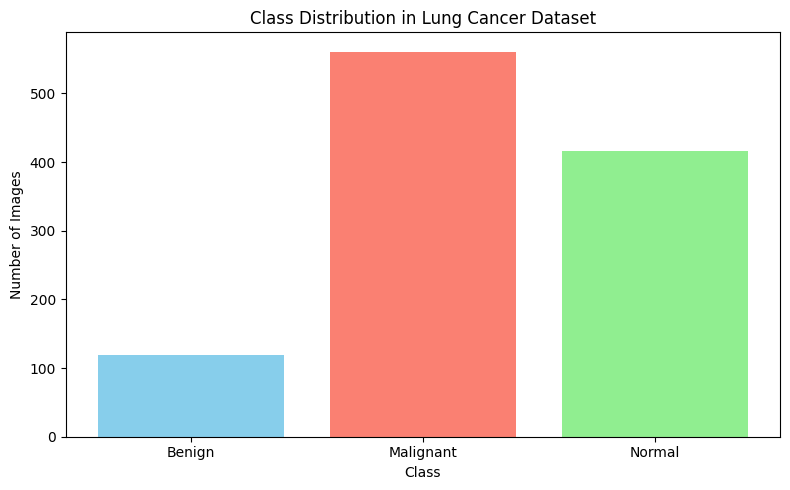

In [12]:

# ✅ 8. Visualize Class Distribution
full_dataset_for_counts = LungCancerClassificationDataset(paths, class_names, transform=None)
class_counts = {
    class_names[0]: len(os.listdir(benign_path)),
    class_names[1]: len(os.listdir(malignant_path)),
    class_names[2]: len(os.listdir(normal_path))
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Class Distribution in Lung Cancer Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.savefig("class_distribution.png")
plt.show()


In [13]:

# ✅ 9. Create datasets with appropriate transforms
train_dataset = LungCancerClassificationDataset(paths, class_names, transform=train_transform)
val_dataset = LungCancerClassificationDataset(paths, class_names, transform=val_test_transform)
test_dataset = LungCancerClassificationDataset(paths, class_names, transform=val_test_transform)


In [14]:

# ✅ 10. Stratified Split with the right transforms
labels = [label for _, label in train_dataset.samples]
indices = list(range(len(labels)))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)
test_dataset = Subset(test_dataset, test_idx)



In [15]:

# ✅ 11. Create data loaders (with dynamic batch sizes implemented later)
default_batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=default_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=default_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=default_batch_size, shuffle=False)


In [16]:

# ✅ 12. Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [17]:

# ✅ 13. Define model architectures
architectures = {
    "ResNet50": models.resnet50,
    "DenseNet121": models.densenet121,
    "EfficientNetB0": models.efficientnet_b0,
    "VGG19": models.vgg19,
    "InceptionV3": models.inception_v3
}


In [18]:

# ✅ 14. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

# Determine available GPU memory (simplified estimation)
if torch.cuda.is_available():
    # Get total GPU memory in MB
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 * 1024)
    # Assume 75% of total memory is available
    available_memory = total_memory * 0.75
else:
    # Default value for CPU
    available_memory = 4000  # 4GB as default

for name in architectures.keys():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")

    # Determine optimal batch size
    batch_size = get_optimal_batch_size(name, available_memory)
    print(f"Using batch size: {batch_size}")

    # Recreate data loaders with optimal batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = get_model(name)
    model = model.to(device)

    # Enable gradient checkpointing
    if torch.cuda.is_available():
        enable_gradient_checkpointing(model, name)

    # Training components
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Train the model
    model = train_with_mixed_precision(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        device, patience=5, max_epochs=20
    )

    # Save the trained model
    model_path = f"{name}_lung_cancer_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Evaluate on test set
    metrics = evaluate_model(model, test_loader, device, num_classes=3)
    metrics["model"] = name
    results.append(metrics)

    # Print metrics summary
    print(f"\nTest Metrics for {name}:")
    for key, value in metrics.items():
        if key != "model":
            print(f"  {key}: {value:.4f}")

    # Clean up to free memory
    del model, optimizer, scheduler, criterion
    free_gpu_memory()

    # Optional: Add a small delay to ensure memory is released
    time.sleep(2)



Training ResNet50...
Using batch size: 64


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.8035, Val Loss: 1.9586
Epoch 2/20, Train Loss: 0.4551, Val Loss: 4.5842
Epoch 3/20, Train Loss: 0.3604, Val Loss: 2.3311
Epoch 4/20, Train Loss: 0.3363, Val Loss: 2.2484
Epoch 5/20, Train Loss: 0.2596, Val Loss: 0.7371
Epoch 6/20, Train Loss: 0.2115, Val Loss: 0.3309
Epoch 7/20, Train Loss: 0.1676, Val Loss: 0.3254
Epoch 8/20, Train Loss: 0.1500, Val Loss: 0.1679
Epoch 9/20, Train Loss: 0.1227, Val Loss: 0.3792
Epoch 10/20, Train Loss: 0.1254, Val Loss: 0.1790
Epoch 11/20, Train Loss: 0.1026, Val Loss: 0.1420
Epoch 12/20, Train Loss: 0.1166, Val Loss: 0.2736
Epoch 13/20, Train Loss: 0.0633, Val Loss: 0.1957
Epoch 14/20, Train Loss: 0.0479, Val Loss: 0.2249
Epoch 15/20, Train Loss: 0.0809, Val Loss: 0.1866
Epoch 16/20, Train Loss: 0.0661, Val Loss: 0.0903
Epoch 17/20, Train Loss: 0.0750, Val Loss: 0.1450
Epoch 18/20, Train Loss: 0.0481, Val Loss: 0.1027
Epoch 19/20, Train Loss: 0.0416, Val Loss: 0.1063
Epoch 20/20, Train Loss: 0.0552, Val Loss: 0.0907
Model sav

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 159MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.9453, Val Loss: 1.4451
Epoch 2/20, Train Loss: 0.6125, Val Loss: 1.8168
Epoch 3/20, Train Loss: 0.4306, Val Loss: 1.6308
Epoch 4/20, Train Loss: 0.3500, Val Loss: 1.0973
Epoch 5/20, Train Loss: 0.2710, Val Loss: 0.5886
Epoch 6/20, Train Loss: 0.2086, Val Loss: 0.2741
Epoch 7/20, Train Loss: 0.1880, Val Loss: 0.2084
Epoch 8/20, Train Loss: 0.1612, Val Loss: 0.2260
Epoch 9/20, Train Loss: 0.1312, Val Loss: 0.1536
Epoch 10/20, Train Loss: 0.1199, Val Loss: 0.1718
Epoch 11/20, Train Loss: 0.1127, Val Loss: 0.1744
Epoch 12/20, Train Loss: 0.1106, Val Loss: 0.1849
Epoch 13/20, Train Loss: 0.0819, Val Loss: 0.1599
Epoch 14/20, Train Loss: 0.0563, Val Loss: 0.1670
Early stopping triggered after 14 epochs
Model saved to DenseNet121_lung_cancer_model.pth

Test Metrics for DenseNet121:
  accuracy: 0.9697
  auc: 0.9970
  sensitivity_class_0: 1.0000
  specificity_class_0: 0.9660
  sensitivity_class_1: 1.0000
  specificity_class_1: 1.0000
  sensitivity_class_2: 0.9206
  spe

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Training EfficientNetB0...
Using batch size: 64


100%|██████████| 20.5M/20.5M [00:00<00:00, 32.2MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 1.0030, Val Loss: 1.1093
Epoch 2/20, Train Loss: 0.7483, Val Loss: 1.1014
Epoch 3/20, Train Loss: 0.5930, Val Loss: 1.1202
Epoch 4/20, Train Loss: 0.4924, Val Loss: 1.7805
Epoch 5/20, Train Loss: 0.4175, Val Loss: 1.4027
Epoch 6/20, Train Loss: 0.3687, Val Loss: 0.7479
Epoch 7/20, Train Loss: 0.3940, Val Loss: 0.4840
Epoch 8/20, Train Loss: 0.3415, Val Loss: 0.4829
Epoch 9/20, Train Loss: 0.3259, Val Loss: 0.4115
Epoch 10/20, Train Loss: 0.3197, Val Loss: 0.4061
Epoch 11/20, Train Loss: 0.2936, Val Loss: 0.3902
Epoch 12/20, Train Loss: 0.2310, Val Loss: 0.3208
Epoch 13/20, Train Loss: 0.2392, Val Loss: 0.2848
Epoch 14/20, Train Loss: 0.2143, Val Loss: 0.2763
Epoch 15/20, Train Loss: 0.1749, Val Loss: 0.2971
Epoch 16/20, Train Loss: 0.1761, Val Loss: 0.2238
Epoch 17/20, Train Loss: 0.1793, Val Loss: 0.2073
Epoch 18/20, Train Loss: 0.1549, Val Loss: 0.2327
Epoch 19/20, Train Loss: 0.1559, Val Loss: 0.1954
Epoch 20/20, Train Loss: 0.1366, Val Loss: 0.2022
Model sav

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 1.1293, Val Loss: 1.0866
Epoch 2/20, Train Loss: 1.1073, Val Loss: 1.0669
Epoch 3/20, Train Loss: 1.0858, Val Loss: 1.0476
Epoch 4/20, Train Loss: 1.0110, Val Loss: 1.0950
Epoch 5/20, Train Loss: 1.0126, Val Loss: 1.0555
Epoch 6/20, Train Loss: 1.0021, Val Loss: 1.0105
Epoch 7/20, Train Loss: 0.9884, Val Loss: 0.9591
Epoch 8/20, Train Loss: 0.8815, Val Loss: 0.8660
Epoch 9/20, Train Loss: 0.8914, Val Loss: 0.9345
Epoch 10/20, Train Loss: 0.9583, Val Loss: 0.8913
Epoch 11/20, Train Loss: 0.7666, Val Loss: 1.1400
Epoch 12/20, Train Loss: 0.7026, Val Loss: 0.6884
Epoch 13/20, Train Loss: 0.6216, Val Loss: 0.6776
Epoch 14/20, Train Loss: 0.5588, Val Loss: 0.6536
Epoch 15/20, Train Loss: 0.4998, Val Loss: 0.7318
Epoch 16/20, Train Loss: 0.5053, Val Loss: 0.5368
Epoch 17/20, Train Loss: 0.4542, Val Loss: 0.6732
Epoch 18/20, Train Loss: 0.4158, Val Loss: 0.4503
Epoch 19/20, Train Loss: 0.3777, Val Loss: 0.6256
Epoch 20/20, Train Loss: 0.3482, Val Loss: 0.3870
Model sav

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 163MB/s]


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:

# ✅ 15. Save and Plot Results
df = pd.DataFrame(results)
df.to_csv("model_evaluation_results.csv", index=False)

# Create visualization of results
metric_names = ["accuracy", "auc"] + [m for m in df.columns if m.startswith("sensitivity") or m.startswith("specificity")]

plt.figure(figsize=(14, 10))
df.set_index("model")[metric_names].plot(kind='bar', figsize=(14, 7))
plt.title("Evaluation Metrics for CNN Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("model_metrics_comparison.png")
plt.show()


In [ ]:

# ✅ 16. Display Confusion Matrices
for name in architectures.keys():
    print(f"\nLoading best model for {name}...")
    model = get_model(name)
    model.load_state_dict(torch.load(f"{name}_lung_cancer_model.pth"))
    model = model.to(device)

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f"{name}_confusion_matrix.png")
    plt.show()

    del model
    free_gpu_memory()

print("\nTraining and evaluation completed for all models.")
print(f"Results saved to 'model_evaluation_results.csv'")
print(f"Visualizations saved as PNG files.")

In [ ]:
# ✅ 17. Model Comparison and Recommendation
def compare_models(results_df):
    print("\nModel Performance Summary:")
    display(results_df.set_index("model"))

    # Compute average specificity and sensitivity
    results_df["avg_sensitivity"] = results_df[[col for col in results_df.columns if col.startswith("sensitivity")]].mean(axis=1)
    results_df["avg_specificity"] = results_df[[col for col in results_df.columns if col.startswith("specificity")]].mean(axis=1)

    # Normalize metrics for comparison
    norm_scores = results_df[["accuracy", "avg_sensitivity", "avg_specificity"]].copy()
    norm_scores = (norm_scores - norm_scores.min()) / (norm_scores.max() - norm_scores.min())
    norm_scores["composite_score"] = norm_scores.mean(axis=1)

    best_model = results_df.loc[norm_scores["composite_score"].idxmax(), "model"]
    print(f"\n✅ Recommended Model: {best_model} (based on accuracy, sensitivity, and specificity)")
    return best_model

In [ ]:
# ✅ 🔍 Compare models and recommend the best
recommended_model = compare_models(df)